# Training Bayesian Neural Networks with `numpyro`

Using code taken from [here](https://num.pyro.ai/en/stable/examples/bnn.html).


## Questions about BNN's and JAX

- Can we train non-bayesian and bayesian parameters at the same time? SGD for non-bayesian parameters and HMC/VI for Bayesian parameters? 
- What is a `jax.devices()`? I have 8 CPU cores, but `jax.devices() == 1`

In [4]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

matplotlib.use("Agg")

In [16]:
# the non-linearity we use in our neural network
def nonlin(x):
    return jax.nn.relu(x)


# a two-layer bayesian neural network with computational flow
# given by D_X => D_H => D_H => D_Y where D_H is the number of
# hidden units. (note we indicate tensor dimensions in the comments)
def model(X, Y, D_H, D_Y=1):
    N, D_X = X.shape

    # sample first layer (we put unit normal priors on all weights)
    w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))
    assert w1.shape == (D_X, D_H)
    z1 = nonlin(jnp.matmul(X, w1))  # <= first layer of activations
    assert z1.shape == (N, D_H)

    # sample second layer
    w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))
    assert w2.shape == (D_H, D_H)
    z2 = nonlin(jnp.matmul(z1, w2))  # <= second layer of activations
    assert z2.shape == (N, D_H)

    # sample final layer of weights and neural network output
    w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))
    assert w3.shape == (D_H, D_Y)
    z3 = jnp.matmul(z2, w3)  # <= output of the neural network
    assert z3.shape == (N, D_Y)

    if Y is not None:
        assert z3.shape == Y.shape

    # we put a prior on the observation noise
    prec_obs = numpyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 1.0 / jnp.sqrt(prec_obs)

    # observe data
    with numpyro.plate("data", N):
        # note we use to_event(1) because each observation has shape (1,)
        numpyro.sample("Y", dist.Normal(z3, sigma_obs).to_event(1), obs=Y)


# helper function for HMC inference
def run_inference(model, num_warmup, num_samples, num_chains, rng_key, X, Y, D_H):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, X, Y, D_H)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()

In [10]:
# helper function for prediction
def predict(model, rng_key, samples, X, D_H):
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    # note that Y will be sampled in the model because we pass Y=None here
    model_trace = handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
    return model_trace["Y"]["value"]


# create artificial regression dataset
def get_data(N=50, D_X=3, sigma_obs=0.05, N_test=500):
    D_Y = 1  # create 1d outputs
    np.random.seed(0)
    X = jnp.linspace(-1, 1, N)
    X = jnp.power(X[:, np.newaxis], jnp.arange(D_X))
    W = 0.5 * np.random.randn(D_X)
    Y = jnp.dot(X, W) + 0.5 * jnp.power(0.5 + X[:, 1], 2.0) * jnp.sin(4.0 * X[:, 1])
    Y += sigma_obs * np.random.randn(N)
    Y = Y[:, np.newaxis]
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = jnp.linspace(-1.3, 1.3, N_test)
    X_test = jnp.power(X_test[:, np.newaxis], jnp.arange(D_X))

    return X, Y, X_test

In [21]:
num_data = 100
num_warmup = 100
num_samples = 500
num_chains = 2

numpyro.set_platform("cpu")
numpyro.set_host_device_count(num_chains)
numpyro.set_host_device_count(num_chains)

N, D_X, D_H = num_data, 3, 2
X, Y, X_test = get_data(N=N, D_X=D_X)

In [23]:
# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model, num_warmup, num_samples, num_chains, rng_key, X, Y, D_H)

/Users/jonny/opt/miniconda3/envs/deeplearn/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 600/600 [00:02<00:00, 207.07it/s, 511 steps of size 7.36e-03. acc. prob=0.78] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs      7.00      4.63      5.29      1.86     13.06      1.05      4.04
   w1[0,0]     -0.46      0.82     -0.35     -1.68      0.54      1.08      3.22
   w1[0,1]      0.53      0.86      0.25     -0.55      1.73      1.09      3.13
   w1[1,0]      1.83      0.84      1.89      0.54      3.09      1.32      1.86
   w1[1,1]      1.48      0.59      1.38      0.52      2.32      8.52      1.08
   w1[2,0]     -0.17      1.68     -0.49     -2.27      2.15      1.05      4.04
   w1[2,1]      0.03      0.73     -0.08     -1.20      1.26     18.43      1.06
   w2[0,0]      0.73      2.11      1.02     -2.08      3.63      1.06      3.58
   w2[0,1]     -0.01      1.44     -0.49     -2.00      2.22      1.17      2.37
   w2[1,0]      0.21      1.52      0.60     -1.97      2.31      1.09      3.08
   w2[1,1]      0.60      0.77      0.67     -0.76      1.74      2.74      1.23
   w3[0,0]      2.43      0

In [ ]:
# predict Y_test at inputs X_test
vmap_args = (
    samples,
    random.split(rng_key_predict, num_samples * num_chains),
)
predictions = vmap(
    lambda samples, rng_key: predict(model, rng_key, samples, X_test, D_H)
)(*vmap_args)
predictions = predictions[..., 0]

# compute mean prediction and confidence interval around median
mean_prediction = jnp.mean(predictions, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

In [ ]:
# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# plot training data
ax.plot(X[:, 1], Y[:, 0], "kx")
# plot 90% confidence level of predictions
ax.fill_between(
    X_test[:, 1], percentiles[0, :], percentiles[1, :], color="lightblue"
)
# plot mean prediction
ax.plot(X_test[:, 1], mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")

In [ ]:
if __name__ == "__main__":
    assert numpyro.__version__.startswith("0.9.1")
    parser = argparse.ArgumentParser(description="Bayesian neural network example")
    parser.add_argument("-n", "--num-samples", nargs="?", default=2000, type=int)
    parser.add_argument("--num-warmup", nargs="?", default=1000, type=int)
    parser.add_argument("--num-chains", nargs="?", default=1, type=int)
    parser.add_argument("--num-data", nargs="?", default=100, type=int)
    parser.add_argument("--num-hidden", nargs="?", default=5, type=int)
    parser.add_argument("--device", default="cpu", type=str, help='use "cpu" or "gpu".')
    args = parser.parse_args()

    numpyro.set_platform(args.device)
    numpyro.set_host_device_count(args.num_chains)

    main(args)

In [ ]:
imagenet_data = torchvision.datasets.ImageNet('path/to/imagenet_root/')
data_loader = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=args.nThreads)

## David Mackay's Book

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import jax
import jax.numpy as np
from jax import random
from jax import jit, grad
from jax import vmap, partial
import numpy as onp

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

key = random.PRNGKey(0)

In [3]:
key, subkey = random.split(key)

x_range = np.linspace(-10, 10, 200)

In [4]:
def plot_fns(fns, idx, interval=250, title='Iteration'):
    x_range = np.linspace(-10, 10, 200)
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.close()
    ax.set(xlim=(-10, 10), ylim=(-10, 10))

    ax.set_title("{}: 0".format(title))
    ax.scatter(D[:, 0], D[:, 1])
    line = ax.plot(x_range, fns[0], color='k', lw=2)[0]

    def animate(i):
        ax.set_title("{}: {}".format(title, idx[i]))
        line.set_ydata(fns[i])

    anim = FuncAnimation(fig, animate, interval=interval, frames=len(idx))
    return anim


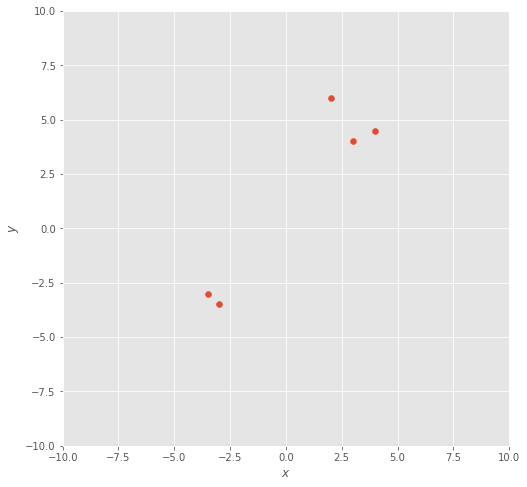

In [6]:
# Multi-layer perceptron
D = np.array([
    (-3, -3.5),
    (2, 6),
    (3, 4),
    (-3.5, -3),
    (4, 4.5),
])
x = D[:, :1]
t = D[:, 1]

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(D[:, 0], D[:, 1])
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [7]:
@jit
def forward_step(W, x):
    W1 = np.expand_dims(W[:N], axis=0)
    W1b = W[N:2 * N]
    W2 = W[2 * N:]

    a1 = np.dot(x, W1) + W1b
    a1 = a1 + W1b
    y1 = np.tanh(a1)
    y_in = np.concatenate((y1, np.ones((y1.shape[0], 1))), axis=1)
    y2 = np.dot(y_in, W2)

    return y2

@jit
def mse_loss(W, x, t):
    y2 = forward_step(W, x)

    error = 0.5 * (y2 - t) ** 2

    return error.sum()

@jit
def regularization_loss(W):
    return 0.5 * (W.dot(W)).sum()

### Maximum Likelihood estimation

In [8]:
eta = 0.005
N = 25
idx = []
fns = []

W = random.normal(key, (3 * N + 1,))

@jit
def step(W, D, t, eta=0.02):
    dW = grad(mse_loss)(W, x, t)
    W = W - eta * dW

    return W

for k in range(10001):
  # Calculate and save for contour lines
  if (k % 500 == 0) or (k <= 1000 and k % 100 == 0):
    idx.append(k)
    y_range = vmap(lambda i: forward_step(W, i))(x_range)
    fns.append(y_range)

  # mse_loss(W, x, t)
  W = step(W, x, t, eta=eta)

fns = np.array(fns)

In [9]:
anim = plot_fns(fns, idx, interval=100, title='Maximum Likelihood - Iteration')
HTML(anim.to_html5_video())

### Add Regularizer

In [10]:
eta = 0.005
N = 25
alpha = 1
idx = []
fns = []

W = random.normal(key, (3 * N + 1,))


@jit
def regularised_loss(W, D, t, alpha):
    return mse_loss(W, D, t) + alpha * regularization_loss(W)


@jit
def step(W, D, t, eta=0.02, alpha=0.1):
    dW = grad(regularised_loss)(W, x, t, alpha)
    W = W - eta * dW

    return W

for k in range(3001):
  # Calculate and save for contour lines
  if (k % 200 == 0) or (k <= 1000 and k % 50 == 0):
    idx.append(k)
    y_range = vmap(lambda i: forward_step(W, i))(x_range)
    fns.append(y_range)

  # mse_loss(W, x, t)
  W = step(W, x, t, eta=eta, alpha=alpha)

fns = np.array(fns)

In [11]:
anim = plot_fns(fns, idx, interval=100, title='Maximum A Posteriori - Iteration')
HTML(anim.to_html5_video())

## Bayesian Methods

### Langevin Monte Carlo method

In [12]:
eta = 0.005
epsilon = np.sqrt(2 * eta)
N = 25
alpha = 1
idx = []
fns = []

W = random.normal(key, (3 * N + 1,))

k0 = 1000

@jit
def loss(W, x, t, alpha):
    return mse_loss(W, x, t) + alpha * regularization_loss(W)


@jit
def step(W, dW, M, k1):
    p = random.normal(k1, (3 * N + 1,))
    H = (p ** 2).sum() / 2 + M

    # For Hamiltonian Monte Carlo, run the following 4 lines for tau iterations, 
    # tau > 1
    p = p - epsilon / 2 * dW
    new_W = W + epsilon * p
    new_dW = grad(loss)(new_W, x, t, alpha=alpha)
    p = p - epsilon / 2 * new_dW

    new_M = loss(new_W, x, t, alpha=alpha)
    new_H = (p ** 2).sum() / 2 + new_M

    dH = new_H - H

    return dH, new_W, new_dW, new_M, k1

accepts = 0
M = loss(W, x, t, alpha=alpha)
dW = grad(loss)(W, x, t, alpha=alpha)

k1, k2 = random.split(key)

for k in range(5001):
    k1, k2 = random.split(k1)
    dH, new_W, new_dW, new_M, k1 = step(W, dW, M, k1)

    if (dH < 0) or (random.uniform(k2) < np.exp(-dH)):
        accepts += 1
        W = new_W
        M = new_M
        dW = new_dW

    if (k <= k0 and k > 0 and k % 10 == 0) or (k > k0 and k % 20 == 0):
        y_range = vmap(lambda i: forward_step(W, i))(x_range)
        fns.append(y_range)
        idx.append(k)

fns = np.array(fns)

In [13]:
anim = plot_fns(fns[:100], range(len(fns[:100])), title='LMC - Sample:')
HTML(anim.to_html5_video())

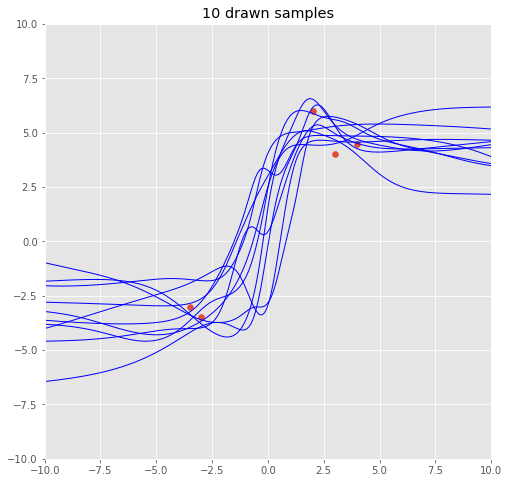

In [14]:
sampled_idx = onp.random.choice(range(fns.shape[0]), 10)
sampled_fns = fns[sampled_idx]

x_range = np.linspace(-10, 10, 200)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set(xlim=(-10, 10), ylim=(-10, 10))

ax.set_title("10 drawn samples")
ax.scatter(D[:, 0], D[:, 1])

for i, fn in enumerate(sampled_fns):
  _ = ax.plot(x_range, fn, color='b', lw=1)

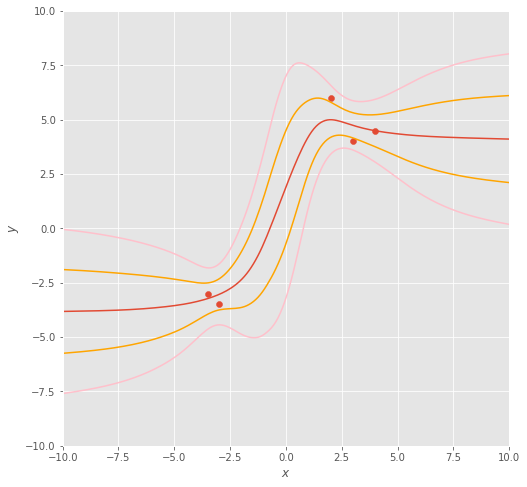

In [15]:
mean_fn = fns.mean(axis=0)
plus_fn = mean_fn + fns.std(axis=0)
minus_fn = mean_fn - fns.std(axis=0)
plus_fn_2 = mean_fn + 1.96 * fns.std(axis=0)
minus_fn_2 = mean_fn - 1.96 * fns.std(axis=0)

plt.figure(figsize=(8, 8))
plt.scatter(D[:, 0], D[:, 1])
plt.plot(x_range, mean_fn)
plt.plot(x_range, plus_fn, color='orange')
plt.plot(x_range, minus_fn, color='orange')
plt.plot(x_range, plus_fn_2, color='pink')
plt.plot(x_range, minus_fn_2, color='pink')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('$x$')
plt.ylabel('$y$');